1. Load Data
2. Handle Missing Values
3. Handling Categorical Values with Order
4. Correlation between Target and Features
5. Correlation within Features
6. Handling Outliers
7. Other Patterns

In [54]:
# -*-coding:utf-8 -*-
import pandas as pd
from os import path
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from itertools import combinations, chain
%matplotlib inline

## 1 Load Data

In [2]:
curdir = path.curdir
train_file = path.join(curdir, "input/train.csv.gz")
test_file = path.join(curdir, "input/test.csv.gz")

train = pd.read_csv(train_file, compression="gzip", index_col="Id", dtype={"MSSubClass": object})
test = pd.read_csv(test_file, compression="gzip", index_col="Id", dtype={"MSSubClass": object})

train.loc[:, "is_test"] = 0
test.loc[:, "is_test"] = 1 
column_order = train.columns

data = pd.concat([train, test]).copy()
data = data[column_order]
del train, test

In [3]:
print(data.shape)
data.head()

(2919, 81)


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,is_test
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,NaN,NaN,NaN,0,2,2008,WD,Normal,208500.0,0
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,NaN,NaN,NaN,0,5,2007,WD,Normal,181500.0,0
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,NaN,NaN,NaN,0,9,2008,WD,Normal,223500.0,0
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000.0,0
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,NaN,NaN,NaN,0,12,2008,WD,Normal,250000.0,0


In [4]:
#train, test set의 주택이 지어진 시기와 매매가 이루어진 시기가 비슷한 수치
data.groupby("is_test").agg({"YearBuilt":['count', 'mean'], 
                            "YrSold": "mean"})

YearBuilt                    YrSold
            count         mean         mean
is_test                                    
0            1460  1971.267808  2007.815753
1            1459  1971.357779  2007.769705

In [5]:
# train, test set의 기본 수치들이 대체로 비슷하다
data.loc[data.is_test == 0,:].describe()

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice,is_test
count,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,1460.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.0
mean,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,46.549315,567.240411,...,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890,0.0
std,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,161.319273,441.866955,...,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883,0.0
min,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000,0.0
25%,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,223.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000,0.0
50%,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,0.000000,477.500000,...,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000,0.0
75%,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,0.000000,808.000000,...,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000,0.0
max,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,2336.000000,...,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000,0.0


In [6]:
data.loc[data.is_test == 1,:].describe()

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice,is_test
count,1232.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1444.000000,1458.000000,1458.000000,1458.000000,...,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,0.0,1459.0
mean,68.580357,9819.161069,6.078821,5.553804,1971.357779,1983.662783,100.709141,439.203704,52.619342,554.294925,...,48.313914,24.243317,1.794380,17.064428,1.744345,58.167923,6.104181,2007.769705,NaN,1.0
std,22.376841,4955.517327,1.436812,1.113740,30.390071,21.130467,177.625900,455.268042,176.753926,437.260486,...,68.883364,67.227765,20.207842,56.609763,30.491646,630.806978,2.722432,1.301740,NaN,0.0
min,21.000000,1470.000000,1.000000,1.000000,1879.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,NaN,1.0
25%,58.000000,7391.000000,5.000000,5.000000,1953.000000,1963.000000,0.000000,0.000000,0.000000,219.250000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,2007.000000,NaN,1.0
50%,67.000000,9399.000000,6.000000,5.000000,1973.000000,1992.000000,0.000000,350.500000,0.000000,460.000000,...,28.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,NaN,1.0
75%,80.000000,11517.500000,7.000000,6.000000,2001.000000,2004.000000,164.000000,753.500000,0.000000,797.750000,...,72.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,NaN,1.0
max,200.000000,56600.000000,10.000000,9.000000,2010.000000,2010.000000,1290.000000,4010.000000,1526.000000,2140.000000,...,742.000000,1012.000000,360.000000,576.000000,800.000000,17000.000000,12.000000,2010.000000,NaN,1.0


In [8]:
# init meta data table
# generate meta data
def get_meta_data(data):
    meta_data = pd.DataFrame({"type": data.dtypes})
    meta_data.loc[:, "na_count"] = data.isnull().sum()
    for row in meta_data.iterrows():
        if row[1].type in [int, float]:
            meta_data.loc[row[0], "tr_max"] = data.loc[data.is_test == 0, row[0]].max()
            meta_data.loc[row[0], "tr_min"] = data.loc[data.is_test == 0, row[0]].min()
            meta_data.loc[row[0], "tr_mean"] = data.loc[data.is_test == 0, row[0]].mean()
        elif row[1].type == object:
            meta_data.loc[row[0], "tr_top"] = data.loc[data.is_test == 0, row[0]].describe().top
    return meta_data

meta_data = get_meta_data(data)
meta_data.head()

,type,na_count,tr_top,tr_max,tr_min,tr_mean
MSSubClass,object,0,20,NaN,NaN,NaN
MSZoning,object,4,RL,NaN,NaN,NaN
LotFrontage,float64,486,NaN,313.0,21.0,70.049958
LotArea,int64,0,NaN,215245.0,1300.0,10516.828082
Street,object,0,Pave,NaN,NaN,NaN


## 2 Handling Missing Values
- missing value count >= 50 의 경우, 하나씩 살펴보면서 적절한 값으로 대체
- missing value count < 50 의 경우 mean 또는 최빈값으로 대체

In [9]:
# missing value count >= 50
meta_data.loc[meta_data.na_count >= 50]

,type,na_count,tr_top,tr_max,tr_min,tr_mean
LotFrontage,float64,486,NaN,313.0,21.0,70.049958
Alley,object,2721,Grvl,NaN,NaN,NaN
BsmtQual,object,81,TA,NaN,NaN,NaN
BsmtCond,object,82,TA,NaN,NaN,NaN
BsmtExposure,object,82,No,NaN,NaN,NaN
BsmtFinType1,object,79,Unf,NaN,NaN,NaN
BsmtFinType2,object,80,Unf,NaN,NaN,NaN
FireplaceQu,object,1420,Gd,NaN,NaN,NaN
GarageType,object,157,Attchd,NaN,NaN,NaN
GarageYrBlt,float64,159,NaN,2010.0,1900.0,1978.506164


In [10]:
# missing value count < 50
meta_data.loc[(meta_data.na_count < 50) & (meta_data.na_count > 0)]

,type,na_count,tr_top,tr_max,tr_min,tr_mean
MSZoning,object,4,RL,NaN,NaN,NaN
Utilities,object,2,AllPub,NaN,NaN,NaN
Exterior1st,object,1,VinylSd,NaN,NaN,NaN
Exterior2nd,object,1,VinylSd,NaN,NaN,NaN
MasVnrType,object,24,None,NaN,NaN,NaN
MasVnrArea,float64,23,NaN,1600.0,0.0,103.685262
BsmtFinSF1,float64,1,NaN,5644.0,0.0,443.639726
BsmtFinSF2,float64,1,NaN,1474.0,0.0,46.549315
BsmtUnfSF,float64,1,NaN,2336.0,0.0,567.240411
TotalBsmtSF,float64,1,NaN,6110.0,0.0,1057.429452


In [11]:
meta_data.loc[(meta_data.na_count < 50) & (meta_data.na_count > 0)].index

Index(['MSZoning', 'Utilities', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF',
       'Electrical', 'BsmtFullBath', 'BsmtHalfBath', 'KitchenQual',
       'Functional', 'GarageCars', 'GarageArea', 'SaleType'],
      dtype='object')

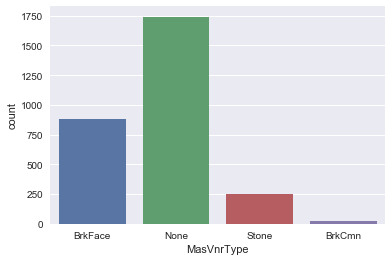

In [12]:
# missing value count < 50 중 특히, missing value가 많은 
# Masonry Veneer Type & Area
# Masonry Veneer Type=="None"타입(Area = 0)이 따로 존재하기 때문에, 
# NULL값을 mean및 mode값으로 대체하는 것이 안전할 것으로 판단
ax = sns.countplot(x="MasVnrType", data=data)

- **missing value count >= 50**: 
    - LotFrontage, GarageYrBlt를 빼면 모두 data_description.txt에 따라 NA로 대체. 모두 미리 정의된 의미있는 수치.

- **missing value count < 50**: 
    - categorical: 따로 항목으로 만들기엔 너무 수가 적기 때문에 최빈값으로 대체
    - numeric: 항목은 모두 mean값으로 처리. 

**LotFrontage w/ Street, Alley**

- missing value가 많은 lot frontage의 경우, 0값이 존재하지 않으므로, NULL값은 0으로 추정

count    2433.000000
mean       69.305795
std        23.344905
min        21.000000
25%        59.000000
50%        68.000000
75%        80.000000
max       313.000000
Name: LotFrontage, dtype: float64

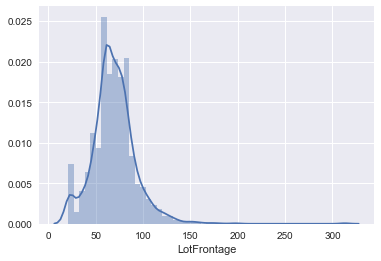

In [13]:
ax = sns.distplot(data.LotFrontage[data.LotFrontage.notnull()])
data.LotFrontage.describe()

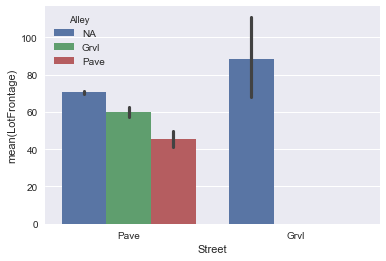

In [14]:
data.loc[:, "Alley"].fillna("NA", inplace=True)
ax = sns.barplot(x="Street", y="LotFrontage",hue="Alley",data=data)

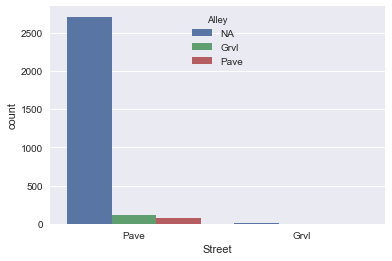

In [15]:
ax = sns.countplot(x="Street",hue="Alley",data=data)

**GarageYrBlt**

- GarageYrBlt가 NULL인 경우는 대부분 GarageType == NA(No Garage)인 경우다. 0과 같이 연도와 무관한 숫자로 대체하는 것은 오래된 garage로 해석될 위험이 있고, 그 영향이 크기 때문에, 평균값으로 대체하기로 한다 

In [16]:
(data.replace({"GarageType":{None: "NA"}})
 .groupby("GarageType")
 .agg({"MSSubClass":"count", "GarageYrBlt":"count"}))

,MSSubClass,GarageYrBlt
GarageType,,
2Types,23,23
Attchd,1723,1723
Basment,36,36
BuiltIn,186,186
CarPort,15,15
Detchd,779,777
NA,157,0


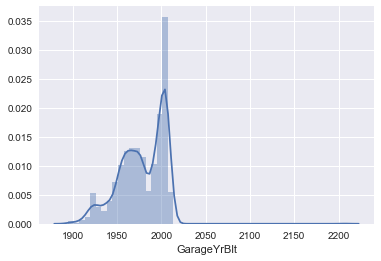

In [17]:
ax = sns.distplot(data.GarageYrBlt[data.GarageYrBlt.notnull()])

In [18]:
#outlier detected (2016년 데이터이기 때문에 2207년 데이터가 있을 수 없다)
data.GarageYrBlt[data.GarageYrBlt > 2016]

Id
2593    2207.0
Name: GarageYrBlt, dtype: float64

In [19]:
def letsfillna(data, meta_data):
    #특정한 값으로 대체하는 경우
    data.loc[:, "LotFrontage"].fillna(0, inplace=True)
    data.loc[:, "GarageYrBlt"].fillna(meta_data.loc["GarageYrBlt"].tr_mean, inplace=True)
    #data.loc[data.loc[:, "GarageYrBlt"] > 2016, "GarageYrBlt"] = 2016
    
    #"NA"로 대체하는 경우
    
    
    #MEAN값 및 최빈값으로 대체하는 경우
    #50개 이하 항목은 categorical항목은 최빈값, numeric 항목은 모두 mean값으로 처리. 따로 항목으로 만들기엔 너무 수가 적음.
    less_than_50 = ['MSZoning', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
                'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF',
                'Electrical', 'BsmtFullBath', 'BsmtHalfBath', 'KitchenQual',
                'Functional', 'GarageCars', 'GarageArea', 'SaleType']
    for col in less_than_50:
        if meta_data.loc[col].type == object:
            data.loc[:, col].fillna(meta_data.loc[col].tr_top, inplace=True)
        elif meta_data.loc[col].type in [float, int]:
            data.loc[:, col].fillna(meta_data.loc[col].tr_mean, inplace=True)
    return 
letsfillna(data, meta_data)

## 3 Handling Categorical Values with Order

In [20]:
for c in data.columns:
    if ("Q" in c or "Cond" in c or c in ["BsmtExposure", "BsmtFinType1", "BsmtFinType2", "Fence"]) and c not in ["Condition1","Condition2","LowQualFinSF", "SaleCondition"]:
        print("\"{}\",".format(c))

"OverallQual",
"OverallCond",
"ExterQual",
"ExterCond",
"BsmtQual",
"BsmtCond",
"BsmtExposure",
"BsmtFinType1",
"BsmtFinType2",
"HeatingQC",
"KitchenQual",
"FireplaceQu",
"GarageQual",
"GarageCond",
"PoolQC",
"Fence",


In [21]:
categorical_feature_with_order = ["OverallQual",
                                "OverallCond",
                                "ExterQual",
                                "ExterCond",
                                "BsmtQual",
                                "BsmtCond",
                                "BsmtExposure",
                                "BsmtFinType1",
                                "BsmtFinType2",
                                "HeatingQC",
                                "KitchenQual",
                                "FireplaceQu",
                                "GarageQual",
                                "GarageCond",
                                "PoolQC"]

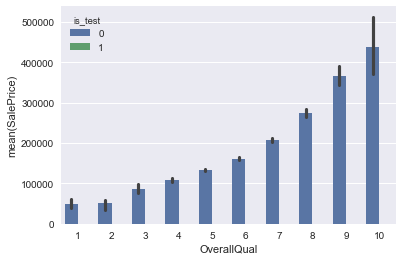

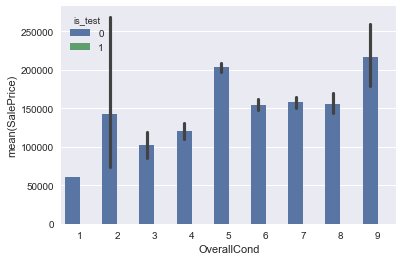

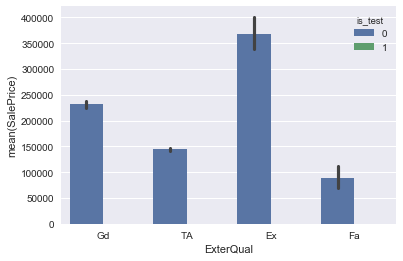

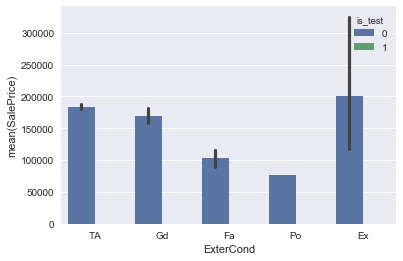

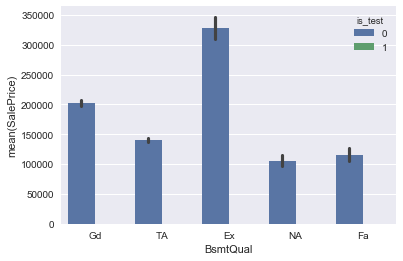

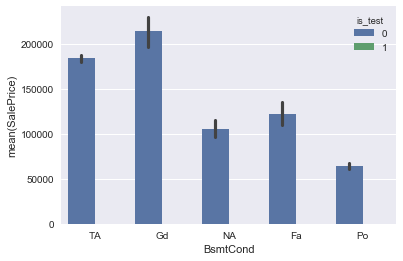

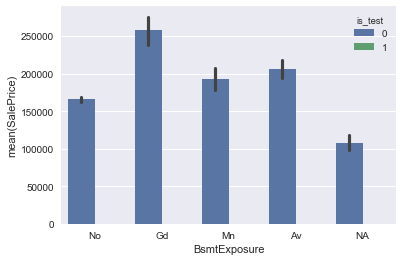

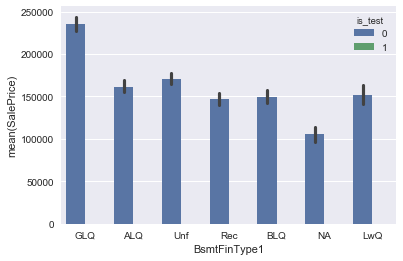

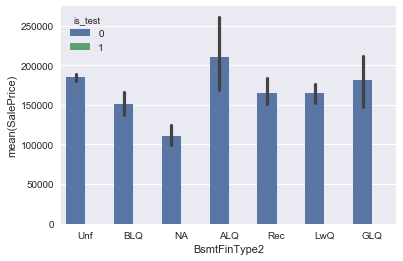

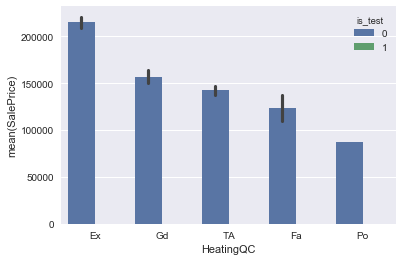

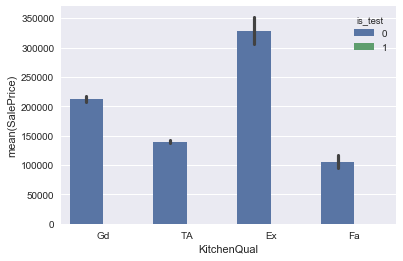

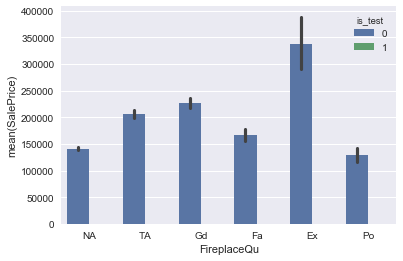

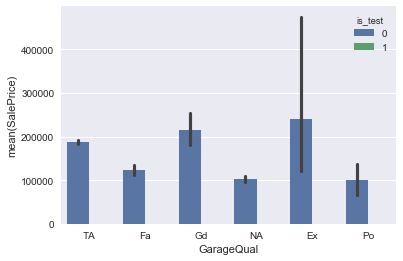

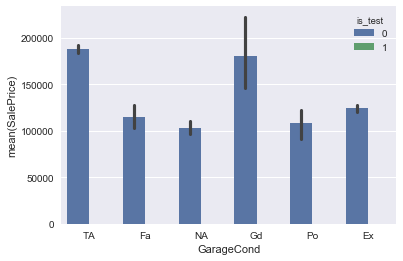

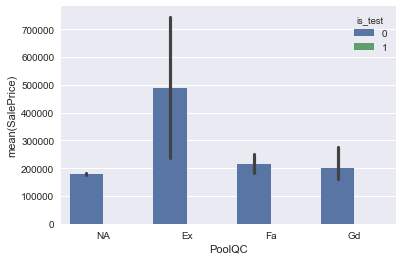

In [22]:
tmp = data.copy()
tmp.loc[:, tuple(categorical_feature_with_order[2:])]=tmp.loc[:, tuple(categorical_feature_with_order[2:])].fillna("NA")
for c in categorical_feature_with_order:
    plt.figure()    
    sns.barplot(x=c, y="SalePrice", hue="is_test", data=tmp)
del tmp

In [23]:
qual_default = {"NA":0, "Po":1, "Fa":2, "TA":3, "Gd":4, "Ex":5}
qual_exp = {"NA":0, "No":1, "Mn":2, "Av":3, "Gd":4}
qual_fin = {"NA":0, "Unf":1, "LwQ":2, "Rec":3, "BLQ":4, "ALQ":5, "GLQ":6}

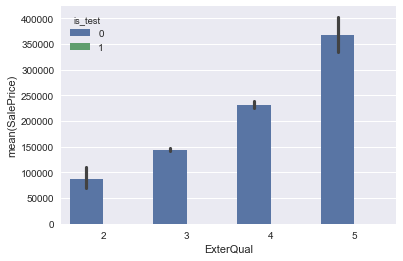

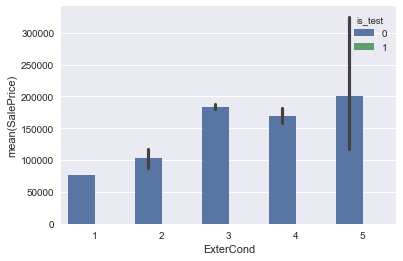

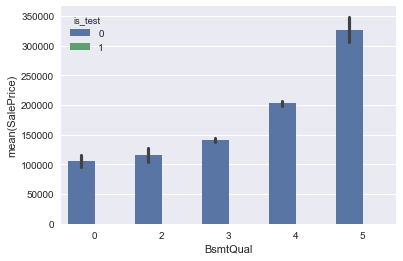

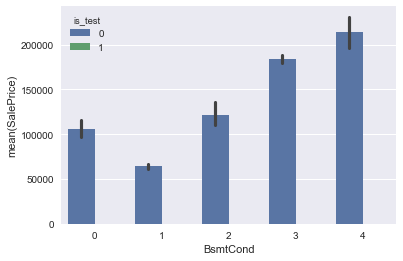

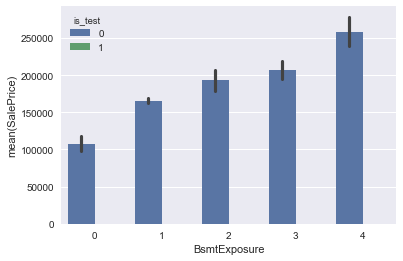

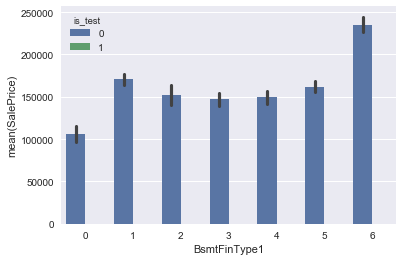

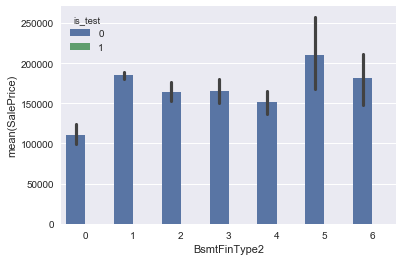

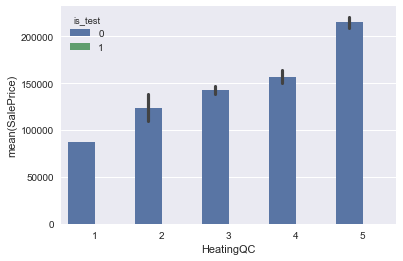

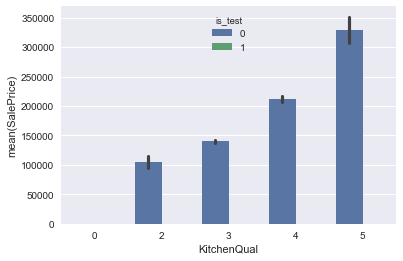

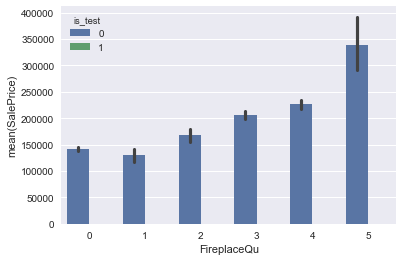

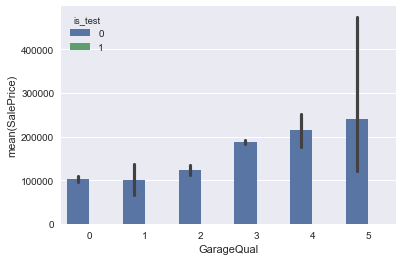

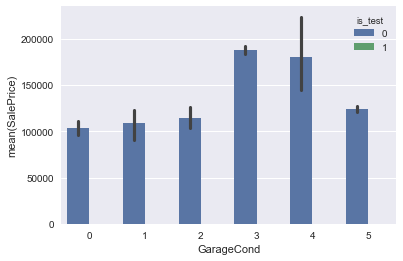

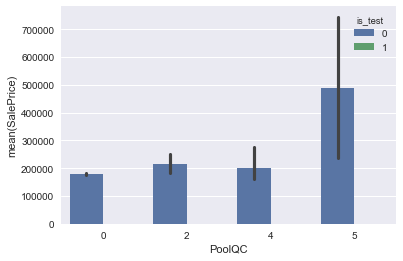

In [23]:
tmp = data.copy()
tmp.loc[:, tuple(categorical_feature_with_order[2:])]=tmp.loc[:, tuple(categorical_feature_with_order[2:])].fillna("NA")
for c in categorical_feature_with_order[2:]:
    plt.figure()
    if c == "BsmtExposure":
        qual_type = qual_exp
    elif c in ["BsmtFinType1", "BsmtFinType2"]:
        qual_type = qual_fin
    else:
        qual_type =qual_default
    tmp.replace({c: qual_type}, inplace=True)
    sns.barplot(x=c, y="SalePrice", hue="is_test", data=tmp)
del tmp

## 4 Analyzing correlation between target and features 
- target distribution: skewed data set 이므로 log를 이용하여, 정규분포에 가깝게 만들어준다. regression을 사용하기 위해선, feature 및 target이 정규분포를 따라야 한다. 다만, 모든 feature가 정규분포를 따르지는 않기 때문에, linear regression의 적용에는 한계가 있을 수 밖에 없다. non parametric model을 통한 보완이 필요하다. 한편, log(SalePrice)로 RMSE를 구하면 RMSLE를 구할 수 있다.
- correlation with target 을 구하여, 예측력이 가장 높을 것으로 예상되는 변수를 살펴본다

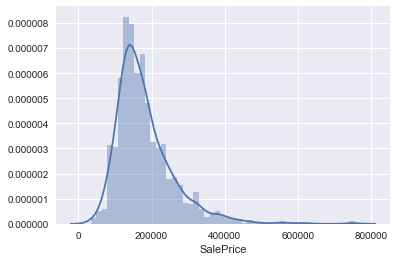

In [25]:
# SalePrice distribution
ax = sns.distplot(data.SalePrice[data.is_test == 0])

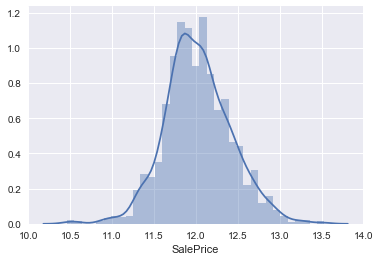

In [28]:
# Log(SalePrice) distribution
ax = sns.distplot(np.log(data.SalePrice[data.is_test == 0]))

In [126]:
data.loc[data.is_test==0, "SalePrice"] = data.loc[data.is_test==0, "SalePrice"].apply(lambda x: np.log(x))

In [127]:
# numeric feature와 saleprice간의 상관관계
for feature in meta_data.loc[meta_data.type != object].index:
    meta_data.loc[
        meta_data.index == feature, "corr_target"] = np.corrcoef(
        data.loc[data.is_test == 0, feature], 
        data.loc[data.is_test == 0, "SalePrice"])[0,1]
# high correlation with saleprice
print(meta_data.loc[(meta_data.type != object) & 
              (np.abs(meta_data.corr_target) > 0.6 ),:].sort_values(
    "corr_target").index)
meta_data.loc[(meta_data.type != object) & 
              (np.abs(meta_data.corr_target) > 0.6 ),:].sort_values(
    "corr_target")

Index(['TotalBsmtSF', 'GarageArea', 'GarageCars', 'GrLivArea', 'OverallQual',
       'SalePrice'],
      dtype='object')


/Users/heekyungyoon/.pyenv/versions/3.6.0/envs/venv36_houseprice/lib/python3.6/site-packages/numpy/lib/function_base.py:3003: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/heekyungyoon/.pyenv/versions/3.6.0/envs/venv36_houseprice/lib/python3.6/site-packages/numpy/lib/function_base.py:3004: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


,type,na_count,tr_top,tr_max,tr_min,tr_mean,corr_target
TotalBsmtSF,float64,1,NaN,6110.0,0.0,1057.429452,0.612134
GarageArea,float64,1,NaN,1418.0,0.0,472.980137,0.650888
GarageCars,float64,1,NaN,4.0,0.0,1.767123,0.680625
GrLivArea,int64,0,NaN,5642.0,334.0,1515.463699,0.700927
OverallQual,int64,0,NaN,10.0,1.0,6.099315,0.817184
SalePrice,float64,1459,NaN,755000.0,34900.0,180921.195890,1.000000


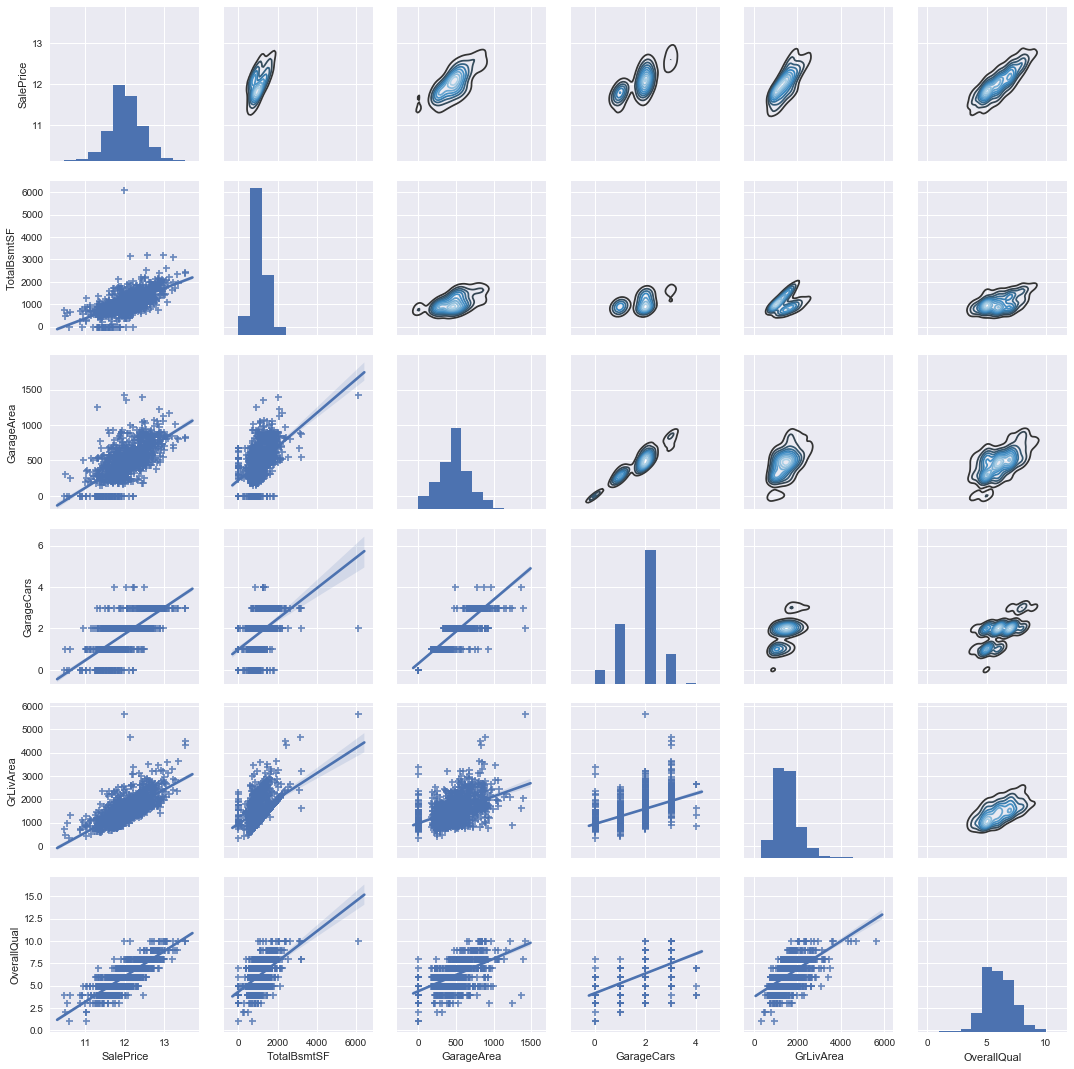

In [129]:
high_corr_target_list = ['SalePrice','TotalBsmtSF', 'GarageArea', 'GarageCars', 'GrLivArea', 'OverallQual']
g = sns.PairGrid(data.loc[data.is_test==0, high_corr_target_list])
g = g.map_lower(sns.regplot, marker="+")
g = g.map_upper(sns.kdeplot, cmap="Blues_d")
g = g.map_diag(plt.hist)

In [131]:
# low correlation with saleprice
print(meta_data.loc[(meta_data.type != object) & 
              (np.abs(meta_data.corr_target) < 0.05),:].sort_values(
    "corr_target").index)

Index(['LowQualFinSF', 'YrSold', 'OverallCond', 'MiscVal', 'BsmtHalfBath',
       'BsmtFinSF2'],
      dtype='object')


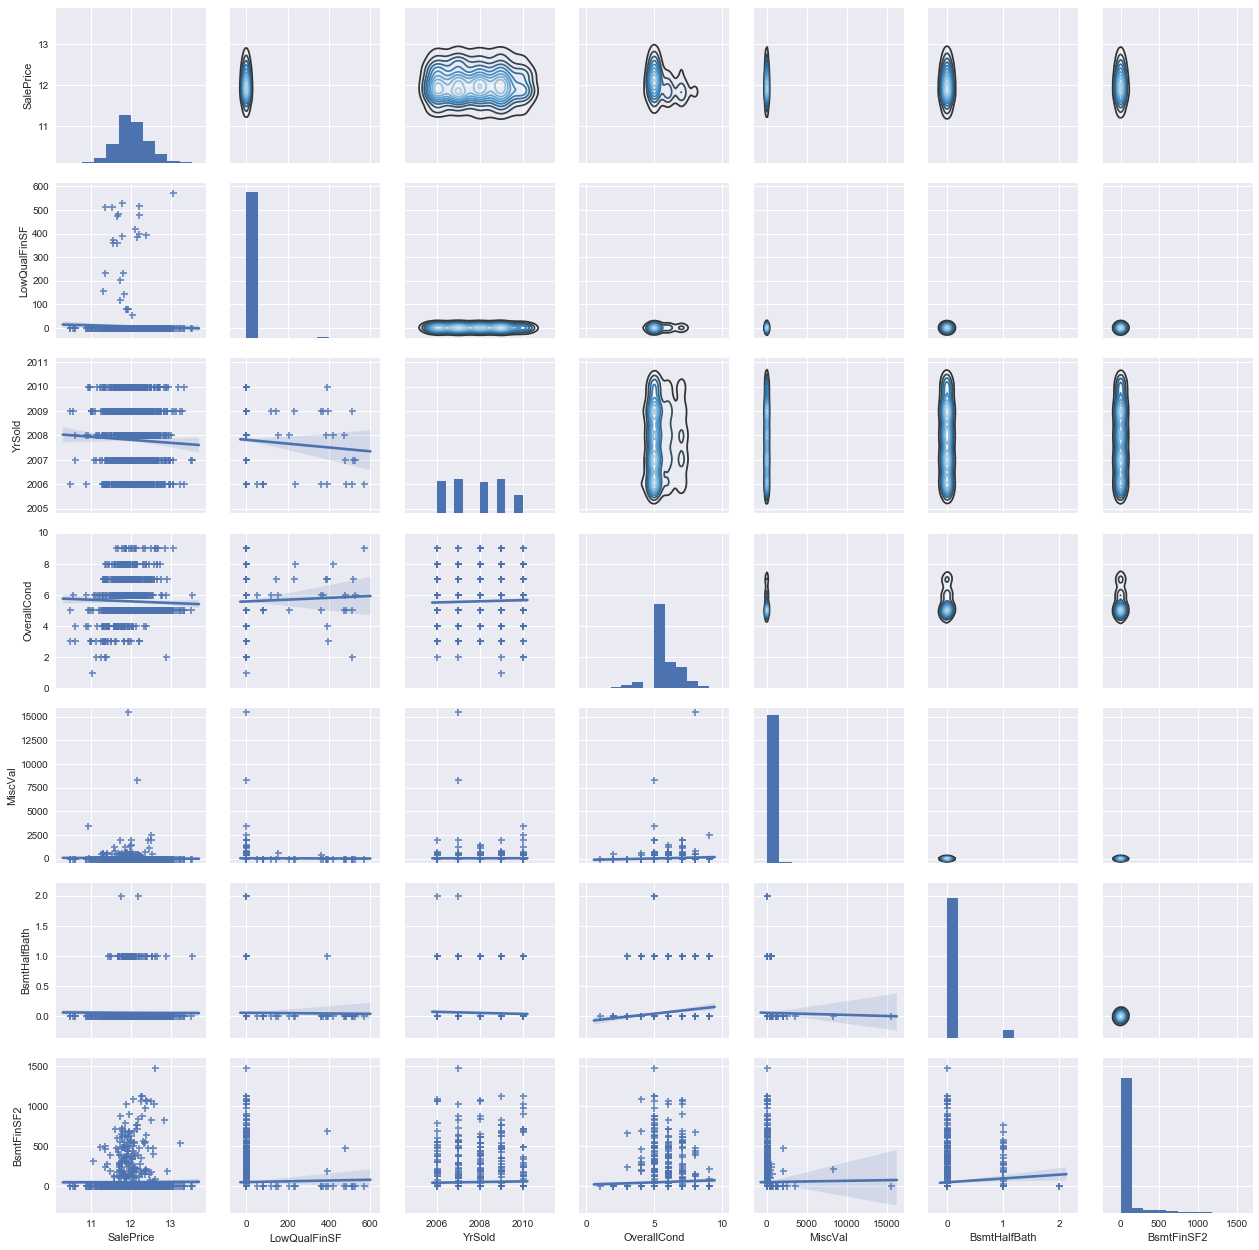

In [132]:
low_corr_target_list = ['SalePrice', 'LowQualFinSF', 'YrSold', 'OverallCond', 'MiscVal', 'BsmtHalfBath',
       'BsmtFinSF2']
g = sns.PairGrid(data.loc[data.is_test==0, low_corr_target_list])
g = g.map_lower(sns.regplot, marker="+")
g = g.map_upper(sns.kdeplot, cmap="Blues_d")
g = g.map_diag(plt.hist)

## 5 Correlation within Features
- feature간의 강한 상관관계를 보이는 경우가 존재한다. 동일한 부분을 설명하는 다양한 속성들이 있기 때문이다. 따라서, linear regression을 적용하는데 한계가 있다. 따라서 polynomial(interaction) feature의 적용이나 non parametric model을 통한 보완이 필요하다 

In [133]:
corr_index = [comb for comb in combinations(meta_data.loc[(meta_data.type != object)&(meta_data.index != "SalePrice")].index,2)]
corr_mtrx = pd.DataFrame({"comb":corr_index, "corr":0})
for comb in combinations(meta_data.loc[(meta_data.type != object)&(meta_data.index != "SalePrice")].index,2):
    corr_mtrx.loc[corr_mtrx.comb == comb, "corr"] = np.corrcoef(
        data.loc[:, comb[0]], 
        data.loc[:, comb[1]])[0,1]

In [134]:
corr_mtrx.sort_values("corr").head()

,comb,corr
225,"(BsmtFinSF1, BsmtUnfSF)",-0.477404
284,"(BsmtUnfSF, BsmtFullBath)",-0.398563
157,"(YearBuilt, EnclosedPorch)",-0.374073
102,"(OverallCond, YearBuilt)",-0.368477
121,"(OverallCond, GarageYrBlt)",-0.304897


In [135]:
corr_mtrx.sort_values("corr", ascending=False).head()

,comb,corr
564,"(GarageCars, GarageArea)",0.889700
405,"(GrLivArea, TotRmsAbvGrd)",0.808354
305,"(TotalBsmtSF, 1stFlrSF)",0.801605
152,"(YearBuilt, GarageYrBlt)",0.789250
495,"(BedroomAbvGr, TotRmsAbvGrd)",0.669737


In [83]:
corr_list = []
for i in chain(corr_mtrx.sort_values("corr").head(2).comb, 
               corr_mtrx.sort_values("corr", ascending=False).head(2).comb):
    if i[0] not in corr_list:
        corr_list.append(i[0])
    if i[1] not in corr_list:
        corr_list.append(i[1])
corr_list

['BsmtFinSF1',
 'BsmtUnfSF',
 'BsmtFullBath',
 'GarageCars',
 'GarageArea',
 'GrLivArea',
 'TotRmsAbvGrd']

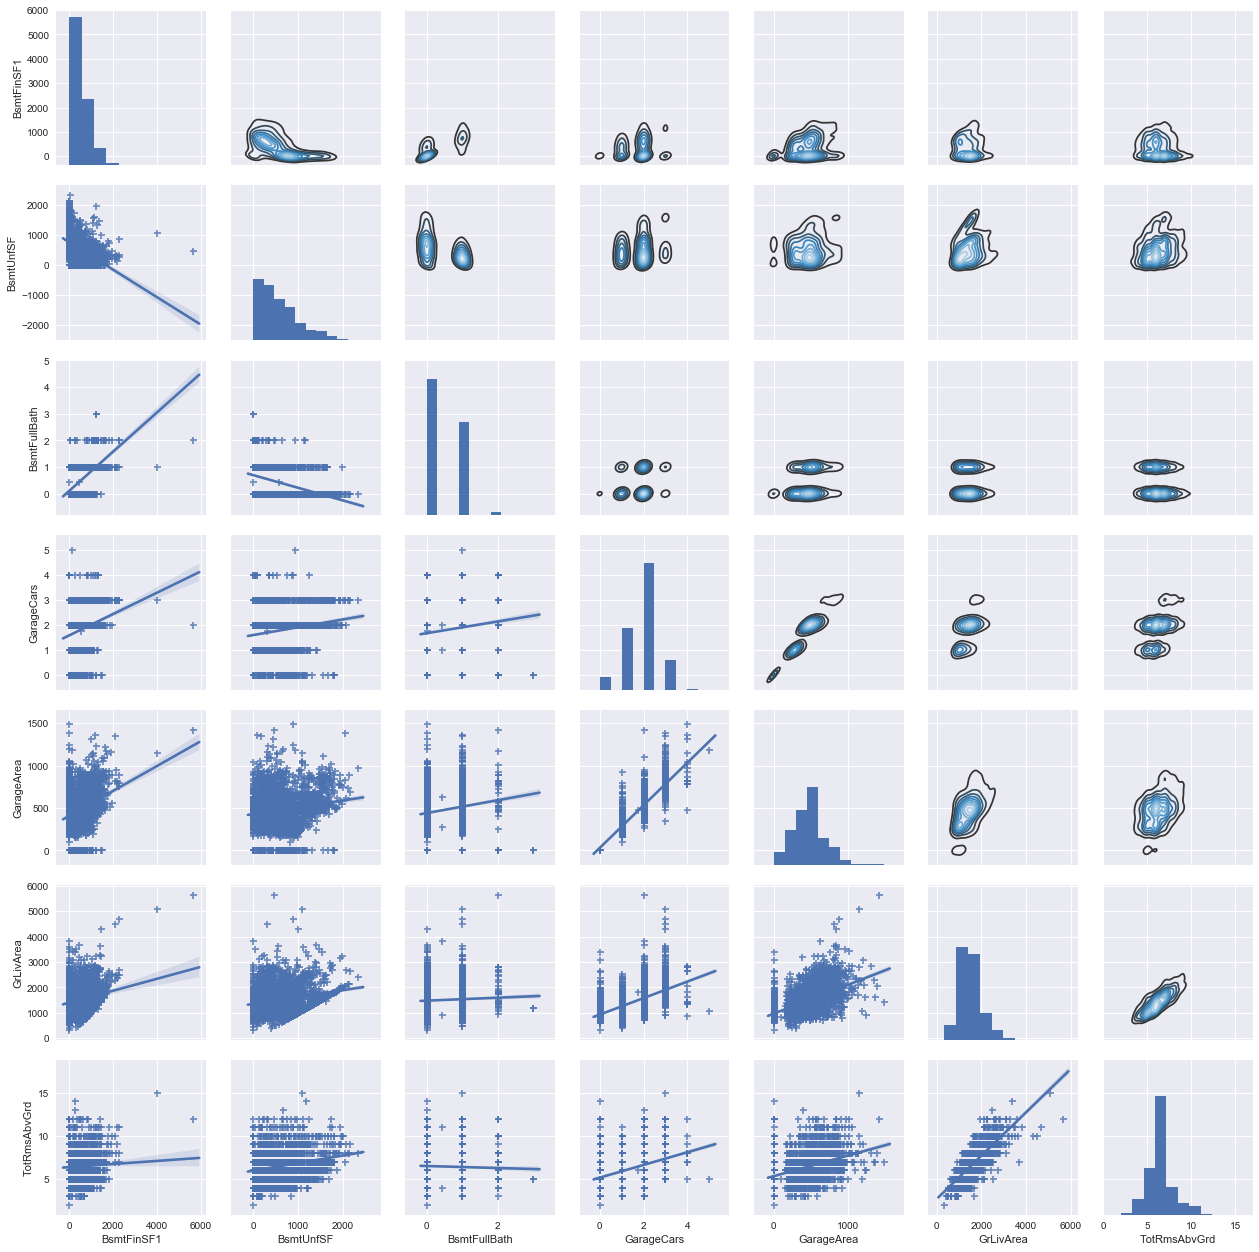

In [84]:
high_corr_list = ['BsmtFinSF1',
 'BsmtUnfSF',
 'BsmtFullBath',
 'GarageCars',
 'GarageArea',
 'GrLivArea',
 'TotRmsAbvGrd']
g = sns.PairGrid(data.loc[:, high_corr_list])
g = g.map_lower(sns.regplot, marker="+")
g = g.map_upper(sns.kdeplot, cmap="Blues_d")
g = g.map_diag(plt.hist)

## 6 Handling outliers

LotArea 29
OverallCond 58
MasVnrArea 63
BsmtFinSF2 92
TotalBsmtSF 21
1stFlrSF 29
LowQualFinSF 31
GrLivArea 25
BsmtHalfBath 175
HalfBath 25
BedroomAbvGr 30
KitchenAbvGr 134
WoodDeckSF 42
OpenPorchSF 51
EnclosedPorch 88
3SsnPorch 36
ScreenPorch 107


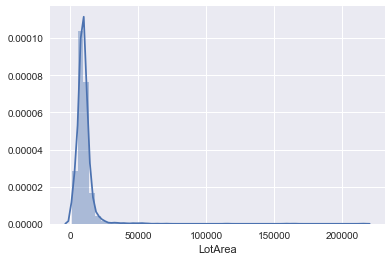

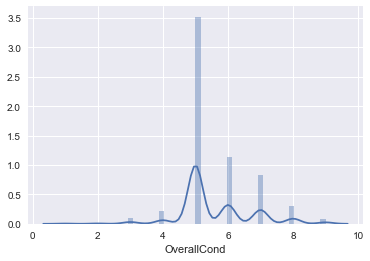

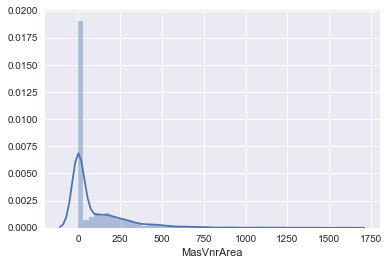

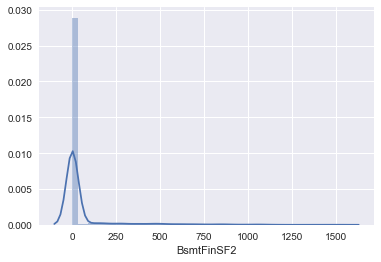

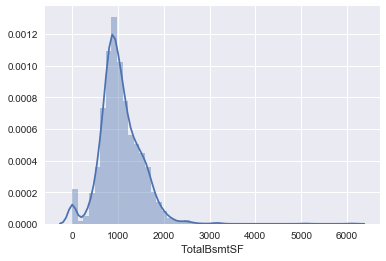

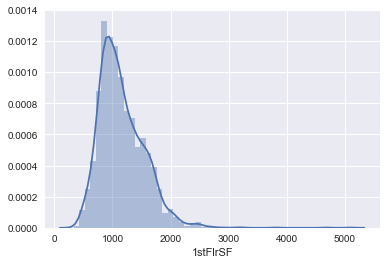

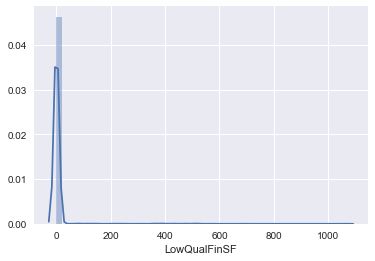

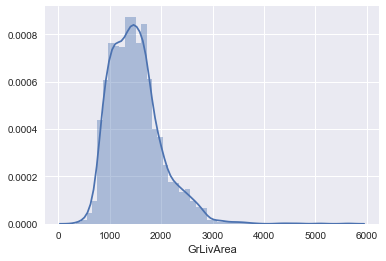

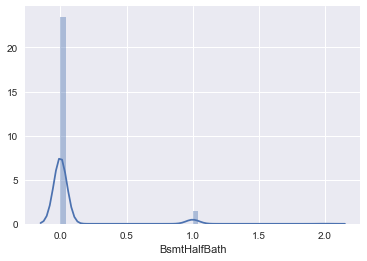

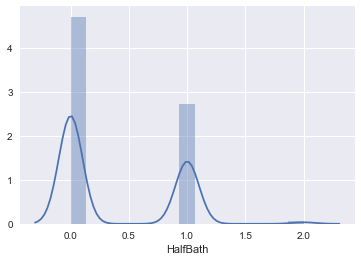

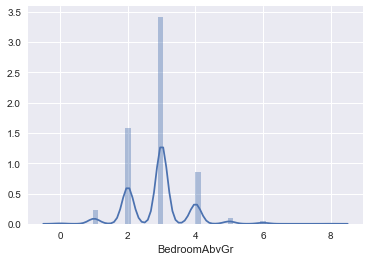

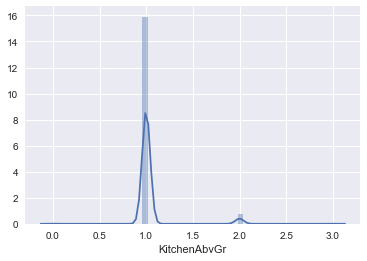

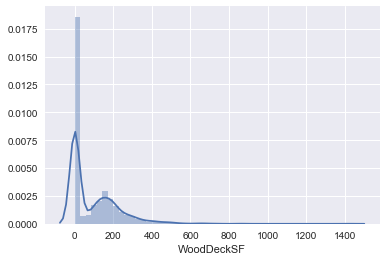

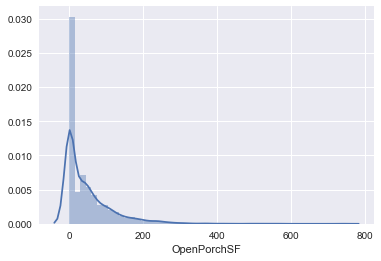

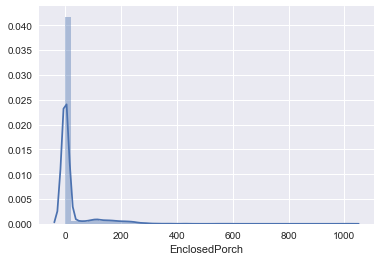

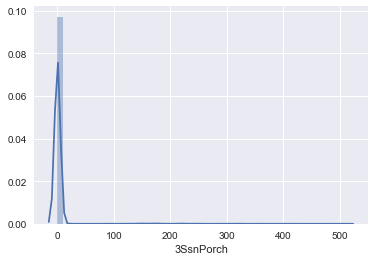

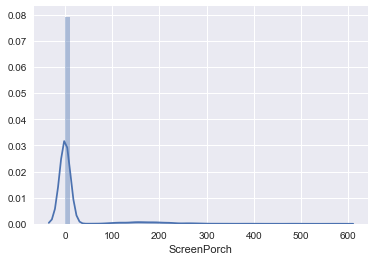

In [116]:
# 절대값이 mean + 3 * standard deviation 보다 큰 수치가 20개 이상 있는 경우
# 대부분이 area, square feet, porch 등 면적과 관계된 수치
area_list = []
for feature in meta_data.loc[(meta_data.type != object) &(meta_data.index != "SalePrice")].index:
    tmp = data.loc[:, feature]
    t = data.loc[(np.abs(tmp - tmp.mean()) >= 3*tmp.std())].shape[0]
    if t > 20:
        area_list.append(feature)
        print(feature, t)
        plt.figure()
        sns.distplot(tmp)

In [118]:
area_list = ['LotArea',
 'MasVnrArea',
 'BsmtFinSF2',
 'TotalBsmtSF',
 '1stFlrSF',
 'LowQualFinSF',
 'GrLivArea',
 'WoodDeckSF',
 'OpenPorchSF',
 'EnclosedPorch',
 '3SsnPorch',
 'ScreenPorch']

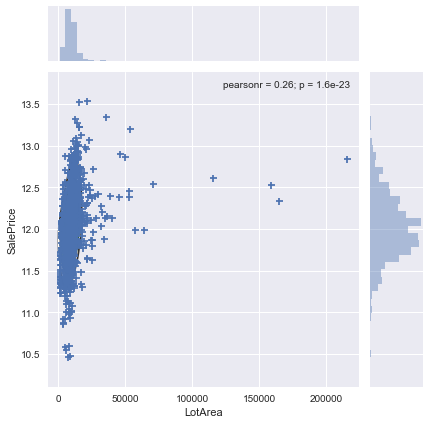

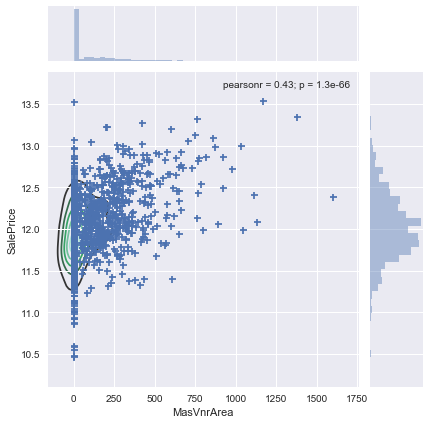

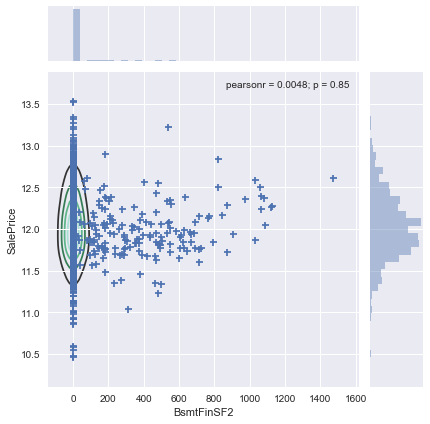

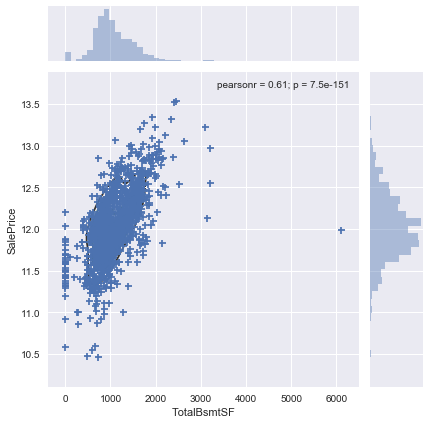

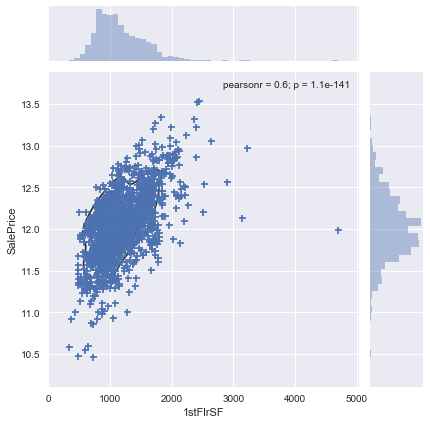

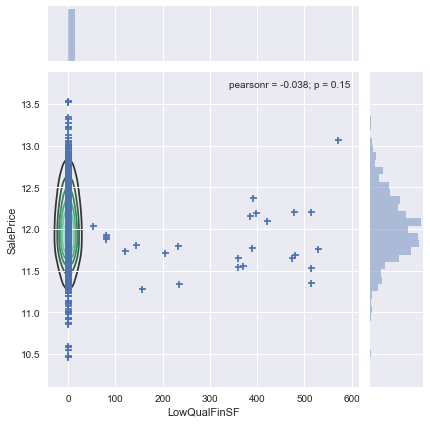

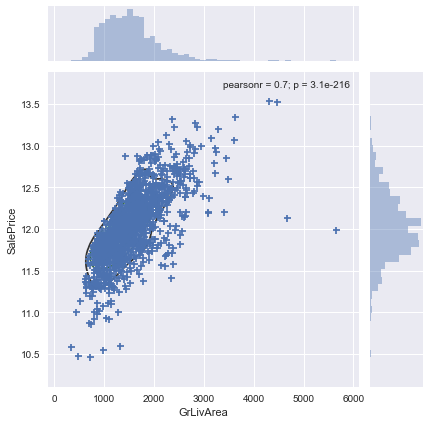

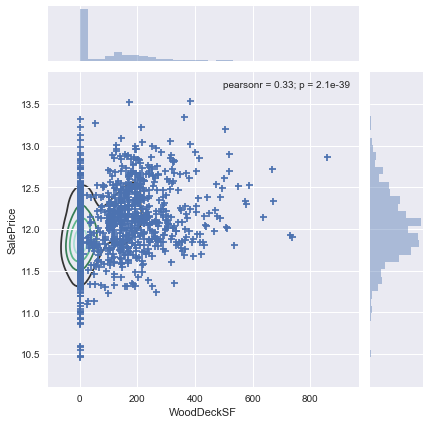

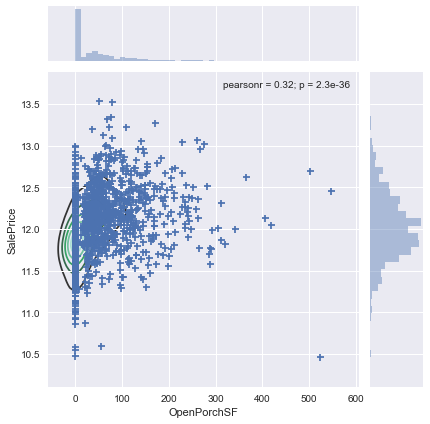

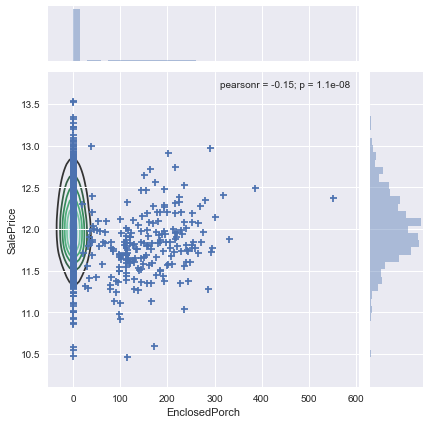

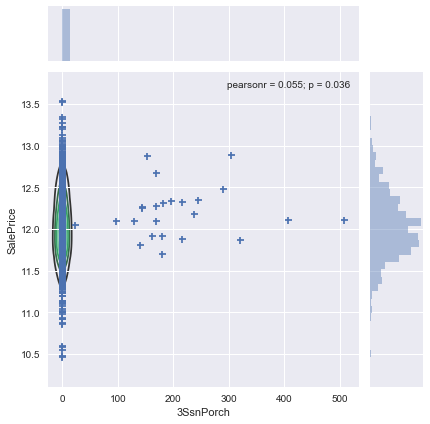

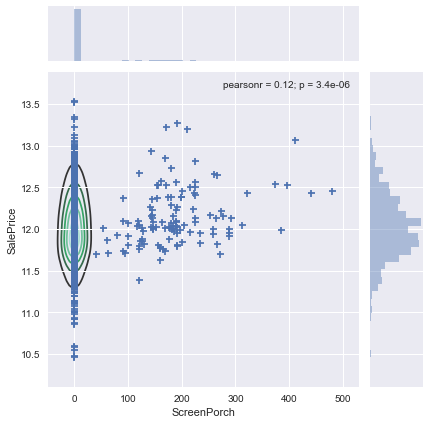

In [140]:
for f in area_list:
    plt.figure
    (sns.jointplot(x=f, y="SalePrice", data=data.loc[(data.is_test==0)], marker="+")
    ).plot_joint(sns.kdeplot, zorder=0, n_levels=6)

- LotArea: outlier가 두드러짐. outlier를 제거할 경우, correlation이 증가하므로 outlier 처리 필요.
- Basement
    - BsmtFinSF2, LowQualFinSF: 베이스먼트 유무와 관계없이 상관관계가 보이지 않는다.
    - TotalBsmtSF outlier가 한 개 있으나, 큰 영향은 없으므로 따로 처리하지 않음
- wood deck이 있는 경우는 sale price와 약한 상관관계를 보이지만, 아예 없는 경우는 전혀 상관이 없으므로, porch 유무 변수 추가3
- porch(open, enclosed) 가 있는 경우는 sale price와 약한 상관관계를 보이지만, 아예 없는 경우는 전혀 상관이 없으므로, porch 유무 변수 추가

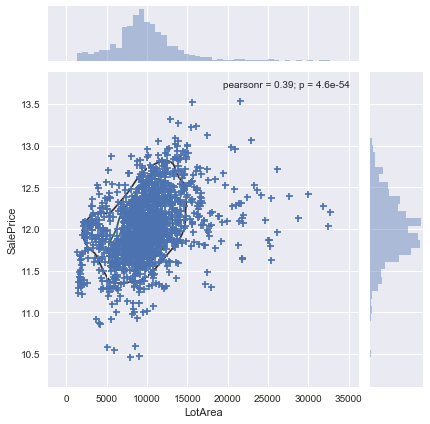

In [142]:
#lot area
ax = (sns.jointplot(x="LotArea", y="SalePrice", 
                    data=data.loc[(data.is_test==0)&
                                  (data.LotArea < data.LotArea.mean() + 3 * data.LotArea.std()
                                  )], marker="+")
    ).plot_joint(sns.kdeplot, zorder=0, n_levels=6)

## 7 Other patterns

**MSSubClass, HouseStyle, BldgType**

- MSSubClass 와 HouseStyle에 층 정보가 겹치기 때문에, MSSubClass는 층정보를 뺀 나머지 정보만 가지고 재정리 해보자

In [244]:
#STORY
data.groupby(["MSSubClass", "HouseStyle"])["OverallQual"].count()

MSSubClass  HouseStyle
120         1Story         180
            SFoyer           2
150         1.5Fin           1
160         2Story         127
            SLvl             1
180         SFoyer          12
            SLvl             5
190         1.5Fin          19
            1.5Unf           1
            1Story          16
            2.5Fin           1
            2.5Unf           3
            2Story          18
            SFoyer           2
            SLvl             1
20          1Story        1077
            2Story           1
            SLvl             1
30          1.5Fin           2
            1.5Unf           1
            1Story         136
40          1.5Fin           1
            1Story           5
45          1.5Fin           2
            1.5Unf          16
50          1.5Fin         282
            1.5Unf           1
            2Story           4
60          1.5Fin           1
            2.5Unf           1
            2Story         572
            SLvl

In [245]:
data.loc[:, "MSSubClass_age"] = data.MSSubClass.copy()
data.loc[:, "MSSubClass_finish"] = data.MSSubClass.copy()

replacement_age = {"MSSubClass_age":{"20": "NEWER", 
                                "30": "OLDER",
                                "40": "ALL",
                                "45": "ALL",
                                "50": "ALL",
                                "60": "NEWER",
                                "70": "OLDER", 
                                "75": "ALL",
                                "80": "ALL", 
                                "85": "ALL",
                                "90": "ALL", 
                                "120": "NEWER",
                                "150": "ALL", 
                                "160":"NEWER", 
                                "180":"ALL", 
                                "190": "ALL"}}

replacement_finish = {"MSSubClass_finish":{"20": "NA", 
                                "30": "NA",
                                "40": "FIN",
                                "45": "UNFIN",
                                "50": "FIN",
                                "60": "NA",
                                "70": "NA", 
                                "75": "NA",
                                "80": "NA",
                                "85": "NA",
                                "90": "NA", 
                                "120": "PUD",
                                "150": "PUD", 
                                "160":"PUD", 
                                "180":"PUD", 
                                "190": "FAM"}}

data.replace(replacement_age, inplace=True)
data.replace(replacement_finish, inplace=True)

In [246]:
data.groupby(["MSSubClass_age", "MSSubClass_finish", "HouseStyle"])["OverallQual"].count()

MSSubClass_age  MSSubClass_finish  HouseStyle
ALL             FAM                1.5Fin          19
                                   1.5Unf           1
                                   1Story          16
                                   2.5Fin           1
                                   2.5Unf           3
                                   2Story          18
                                   SFoyer           2
                                   SLvl             1
                FIN                1.5Fin         283
                                   1.5Unf           1
                                   1Story           5
                                   2Story           4
                NA                 1.5Fin           5
                                   1Story          57
                                   2.5Fin           6
                                   2.5Unf          17
                                   2Story          27
                                   S

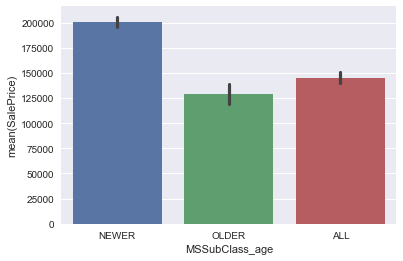

In [247]:
ax = sns.barplot(x="MSSubClass_age",y="SalePrice",data=data)

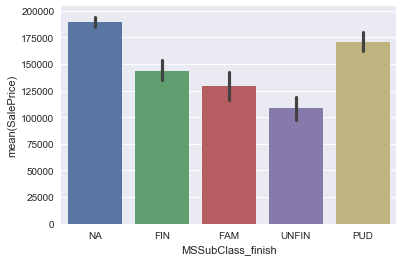

In [248]:
ax = sns.barplot(x="MSSubClass_finish",y="SalePrice",data=data)

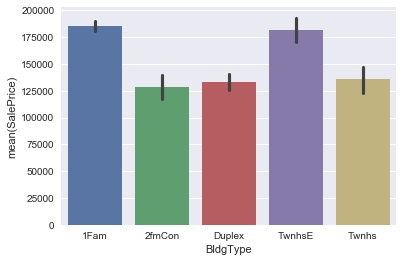

In [342]:
ax = sns.barplot(x="BldgType",y="SalePrice",data=data)

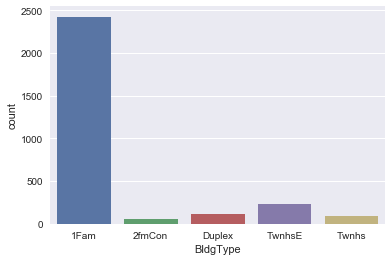

In [343]:
ax = sns.countplot(x="BldgType",data=data)

**MSZoning, Neighborhood**

- Floating Village Residential 이 가장 비싸고, Residential Low Density가 가장 대중적인 구역이다
- train, test set의 분포 차이는 거의 없다
- Neighborhood의 경우 10건 이하의 경우, 예측항목보다는 노이즈로 작용할 가능성이 크므로 모두 etc로 처리

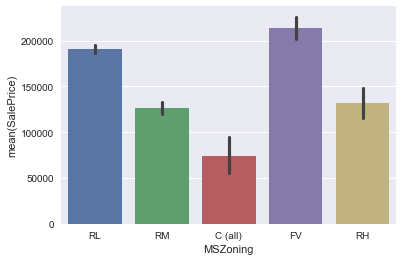

In [249]:
ax = sns.barplot(x="MSZoning",y="SalePrice",data=data)

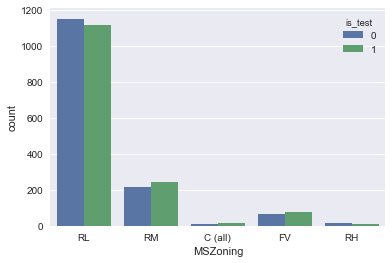

In [250]:
ax = sns.countplot(x="MSZoning", hue="is_test",data=data)

In [253]:
t = data.groupby(["MSZoning", "Neighborhood"])["SalePrice"].count()
t

MSZoning  Neighborhood
C (all)   IDOTRR            9
          OldTown           1
          SWISU             0
FV        Somerst          65
RH        Crawfor           2
          Edwards           2
          NAmes             2
          SWISU             5
          SawyerW           5
RL        Blmngtn          16
          BrkSide          28
          ClearCr          28
          CollgCr         140
          Crawfor          46
          Edwards          90
          Gilbert          79
          Mitchel          44
          NAmes           223
          NPkVill           9
          NWAmes           73
          NoRidge          41
          NridgHt          76
          OldTown          17
          SWISU            20
          Sawyer           72
          SawyerW          54
          Somerst          21
          StoneBr          25
          Timber           38
          Veenker          11
RM        Blmngtn           1
          Blueste           2
          BrDale 

In [273]:
# count <= 10 -> "Etc"
t[t <= 10].index.get_level_values(1).values

array(['IDOTRR', 'OldTown', 'SWISU', 'Crawfor', 'Edwards', 'NAmes',
       'SWISU', 'SawyerW', 'NPkVill', 'Blmngtn', 'Blueste', 'CollgCr',
       'Crawfor', 'Edwards', 'Mitchel', 'NridgHt', 'Sawyer'], dtype=object)

**LotArea, LotShape, LandContour, LandSlope**
- test, train set의 분포가 비슷하며, missing value가 없다

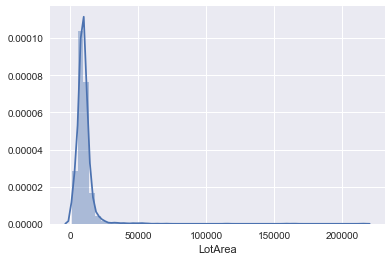

In [323]:
ax = sns.distplot(data.LotArea)

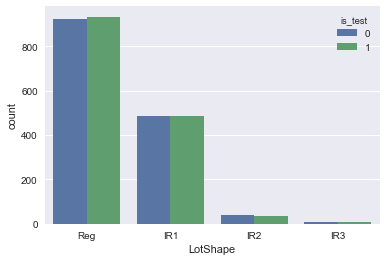

In [325]:
ax = sns.countplot(x="LotShape", hue="is_test",data=data)

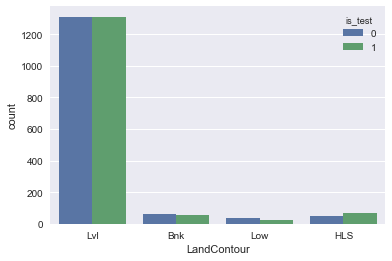

In [326]:
ax = sns.countplot(x="LandContour", hue="is_test",data=data)

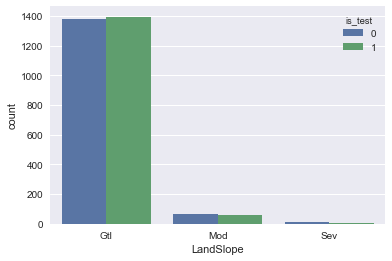

In [327]:
ax = sns.countplot(x="LandSlope", hue="is_test",data=data)

**Utilities**
- 거의 constant에 가까우므로 제거 

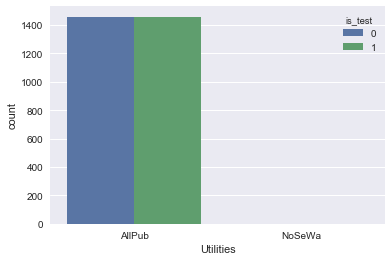

In [329]:
ax = sns.countplot(x="Utilities", hue="is_test",data=data)

In [331]:
data.groupby("Utilities")["MSSubClass"].count()

Utilities
AllPub    2916
NoSeWa       1
Name: MSSubClass, dtype: int64

**Condition1, 2**

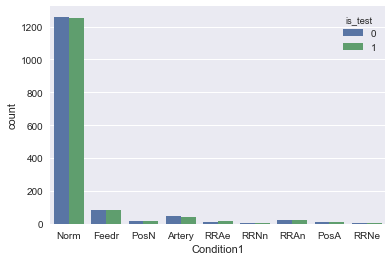

In [334]:
ax = sns.countplot(x="Condition1", hue="is_test",data=data)

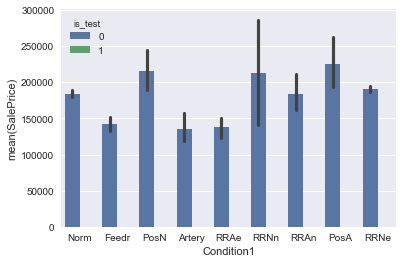

In [335]:
ax = sns.barplot(x="Condition1", y="SalePrice",hue="is_test",data=data)

In [339]:
data.groupby("Condition1").agg({"MSSubClass":"count", "SalePrice":"mean"})

,MSSubClass,SalePrice
Condition1,,
Artery,92,135091.666667
Feedr,164,142475.481481
Norm,2511,184495.492063
PosA,20,225875.000000
PosN,39,215184.210526
RRAe,28,138400.000000
RRAn,50,184396.615385
RRNe,6,190750.000000
RRNn,9,212400.000000


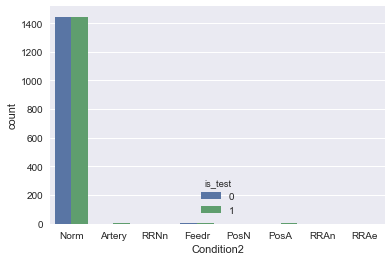

In [336]:
ax = sns.countplot(x="Condition2", hue="is_test",data=data)

In [337]:
data.groupby("Condition2")["MSSubClass"].count()

Condition2
Artery       5
Feedr       13
Norm      2889
PosA         4
PosN         4
RRAe         1
RRAn         1
RRNn         2
Name: MSSubClass, dtype: int64

**OverallQual, OverallCond**

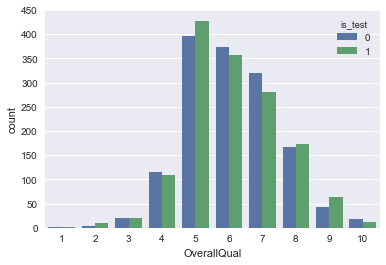

In [345]:
ax = sns.countplot(x="OverallQual", hue="is_test",data=data)

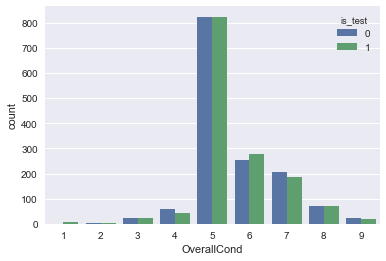

In [346]:
ax = sns.countplot(x="OverallCond", hue="is_test",data=data)

**YearBuilt, YearRemodAdd, YrSold, MoSold**

- YrSold, MoSold와 SalePrice는 관련이 없다
- YrSold에 비교하여 YearBuilt, YearRemodAdd와의 차이를 구해보았으나, YrSold가 2006-2010사이로 매우 좁은 간격이라, 큰 의미는 없어, 항목을 추가하지 않았다
- 여름시즌에 매매가 집중되었다. 패턴상, numeric value보다는 categorical value로 처리되는 것이 예측력에 도움이 될 것으로 보인다. 

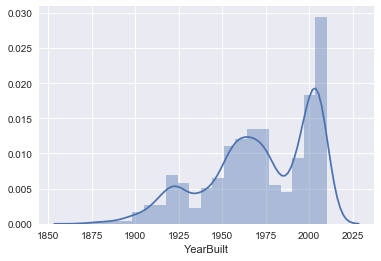

In [349]:
ax = sns.distplot(data.YearBuilt)

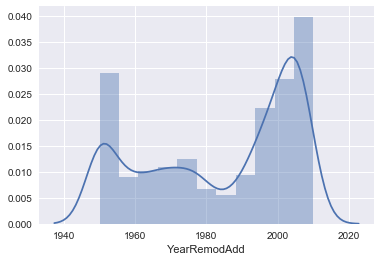

In [350]:
ax = sns.distplot(data.YearRemodAdd)

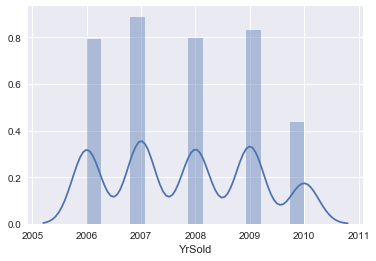

In [374]:
ax = sns.distplot(data.YrSold)

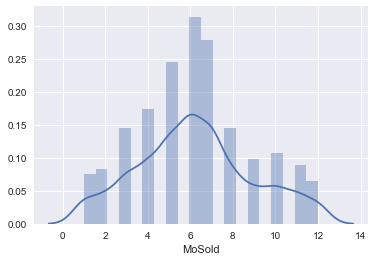

In [381]:
ax = sns.distplot(data.MoSold)

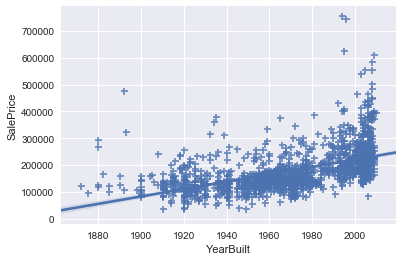

In [378]:
ax = sns.regplot(x="YearBuilt", y="SalePrice", data=data, marker="+")

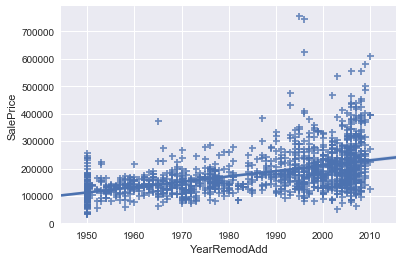

In [373]:
ax = sns.regplot(x="YearRemodAdd", y="SalePrice", data=data, marker="+")

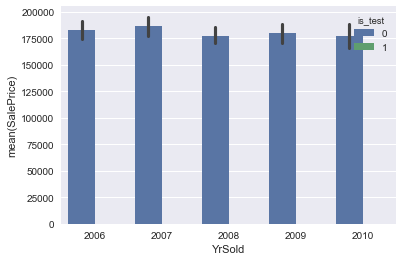

In [375]:
ax = sns.barplot(x="YrSold", y="SalePrice",hue="is_test",data=data)

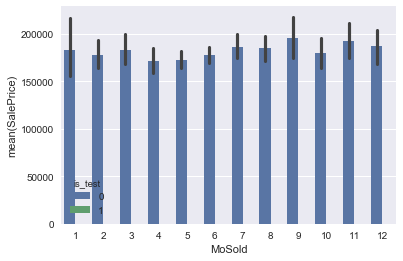

In [382]:
ax = sns.barplot(x="MoSold", y="SalePrice",hue="is_test",data=data)

In [379]:
data.loc[:, "RemodAddToSale"] = data.loc[:, ("YrSold", "YearRemodAdd")].apply(lambda row: row.YrSold - row.YearRemodAdd, axis=1)
data.loc[:, "BuiltToSale"] = data.loc[:, ("YrSold", "YearBuilt")].apply(lambda row: row.YrSold - row.YearBuilt, axis=1)


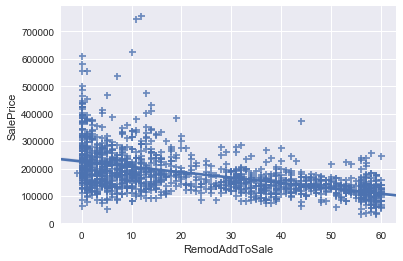

In [372]:
ax = sns.regplot(x="RemodAddToSale", y="SalePrice",data=data, marker="+")

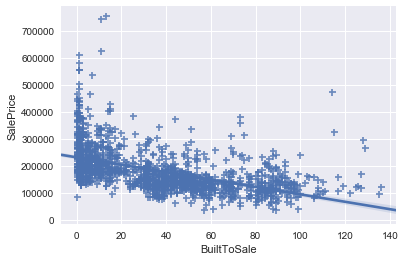

In [380]:
ax = sns.regplot(x="BuiltToSale", y="SalePrice",data=data, marker="+")

**SaleType, SaleCondition**

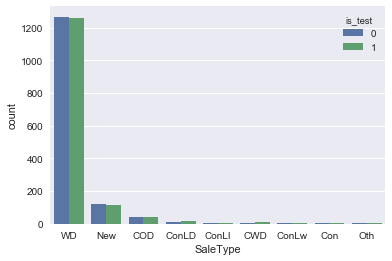

In [383]:
ax = sns.countplot(x="SaleType",hue="is_test",data=data)

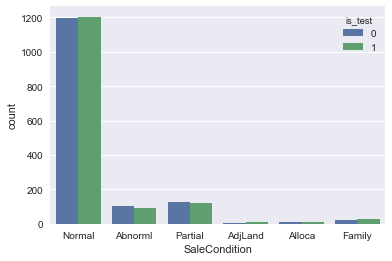

In [384]:
ax = sns.countplot(x="SaleCondition",hue="is_test",data=data)

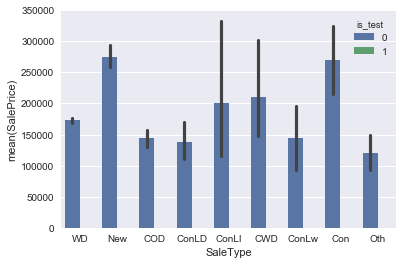

In [385]:
ax = sns.barplot(x="SaleType", y="SalePrice",hue="is_test",data=data)

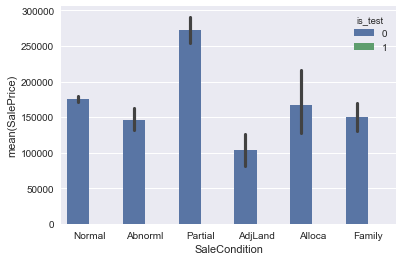

In [386]:
ax = sns.barplot(x="SaleCondition", y="SalePrice",hue="is_test",data=data)